2. 使用RNN实现一个天气预测模型，能预测1天和连续5天的最高气温。要求使用tensorboard，提交代码及run目录和可视化截图。
   数据集：URL_ADDRESS   数据集：https://www.kaggle.com/datasets/smid80/weatherww2

In [1]:
# 1. 数据准备与预处理
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 加载数据
data = pd.read_csv('./data/Summary of Weather.csv', low_memory=False)

# 选择需要的列并处理缺失值
data = data[['Date', 'MaxTemp']].dropna()
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# 数据归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
data['MaxTemp'] = scaler.fit_transform(data['MaxTemp'].values.reshape(-1, 1))

# 创建序列数据，滑动窗口（仅预测1天）
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):  # 只需要额外1天用于预测
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]  # 只预测1天
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # 使用30天的数据预测未来1天
X, y = create_sequences(data['MaxTemp'].values, seq_length)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 创建PyTorch数据集（简化版）
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        # 转换为PyTorch张量并在末尾添加一个维度
        self.X = torch.FloatTensor(X).unsqueeze(-1)  # 形状: [样本数, seq_length, 1]
        self.y = torch.FloatTensor(y).unsqueeze(-1)  # 形状: [样本数, 1]
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # 只返回单日预测目标

train_dataset = WeatherDataset(X_train, y_train)
test_dataset = WeatherDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
# 2. RNN模型定义
class DeepRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(DeepRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN层
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, output_size)  # 预测1天
        
    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # RNN前向传播
        out, _ = self.rnn(x, h0)
        
        # 只使用最后一个时间步的输出进行预测
        out = out[:, -1, :]
        
        # 预测1天
        pred1 = self.fc(out)
        
        return pred1


In [ ]:
# 3. 训练与评估（单日预测版本）
# 初始化模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepRNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# TensorBoard记录器
writer = SummaryWriter('runs/weather_prediction_single_day')

# 训练函数（单日预测）
def train(model, dataloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):  # 注意：现在targets是单值
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 前向传播
        optimizer.zero_grad()
        pred = model(inputs)  # 模型现在只输出单日预测
        
        # 计算损失（仅单日预测）
        loss = criterion(pred, targets)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # 每100个batch记录一次
        if batch_idx % 100 == 99:
            writer.add_scalar('training loss', running_loss/100, epoch*len(dataloader)+batch_idx)
            running_loss = 0.0
    
    return running_loss / len(dataloader)

# 测试函数（单日预测）
def test(model, dataloader, criterion, epoch):
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            pred = model(inputs)  # 单日预测
            
            loss = criterion(pred, targets)
            test_loss += loss.item()
    
    test_loss /= len(dataloader)
    writer.add_scalar('test loss', test_loss, epoch)
    
    return test_loss

# 训练循环
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    test_loss = test(model, test_loader, criterion, epoch)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

# 关闭TensorBoard写入器
writer.close()


Epoch 1/20, Train Loss: 0.002616, Test Loss: 0.030836
Epoch 2/20, Train Loss: 0.002708, Test Loss: 0.030901
Epoch 3/20, Train Loss: 0.002512, Test Loss: 0.030512
Epoch 4/20, Train Loss: 0.002705, Test Loss: 0.031056
Epoch 5/20, Train Loss: 0.002690, Test Loss: 0.029782
Epoch 6/20, Train Loss: 0.002745, Test Loss: 0.030569
Epoch 7/20, Train Loss: 0.002642, Test Loss: 0.031251
Epoch 8/20, Train Loss: 0.002665, Test Loss: 0.030269
Epoch 9/20, Train Loss: 0.002696, Test Loss: 0.030256
Epoch 10/20, Train Loss: 0.002689, Test Loss: 0.030406
Epoch 11/20, Train Loss: 0.002697, Test Loss: 0.030079
Epoch 12/20, Train Loss: 0.002623, Test Loss: 0.031497
Epoch 13/20, Train Loss: 0.002558, Test Loss: 0.029894
Epoch 14/20, Train Loss: 0.002282, Test Loss: 0.030300
Epoch 15/20, Train Loss: 0.002630, Test Loss: 0.029854
Epoch 16/20, Train Loss: 0.002521, Test Loss: 0.030016
Epoch 17/20, Train Loss: 0.002767, Test Loss: 0.030007
Epoch 18/20, Train Loss: 0.002584, Test Loss: 0.030477
Epoch 19/20, Train 

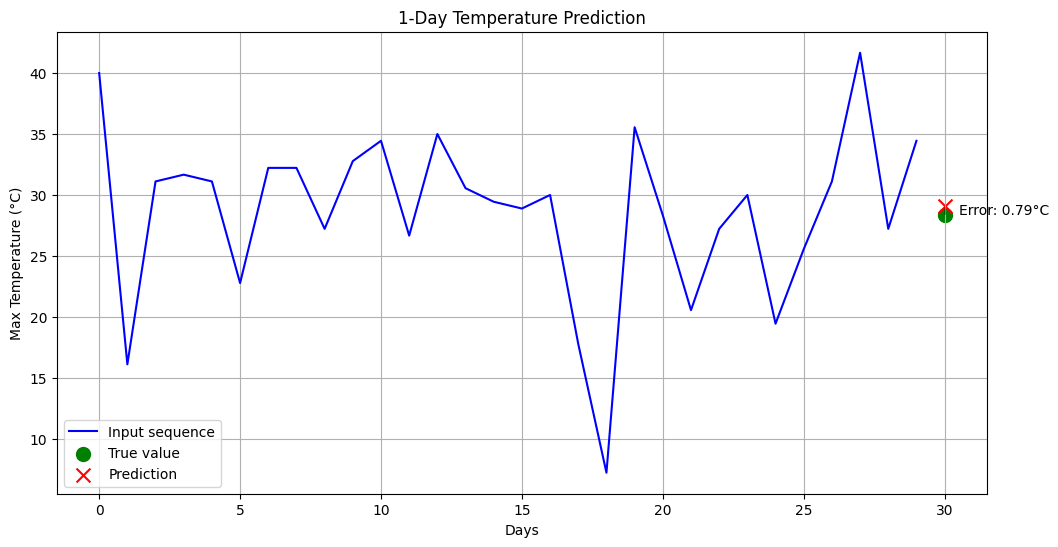

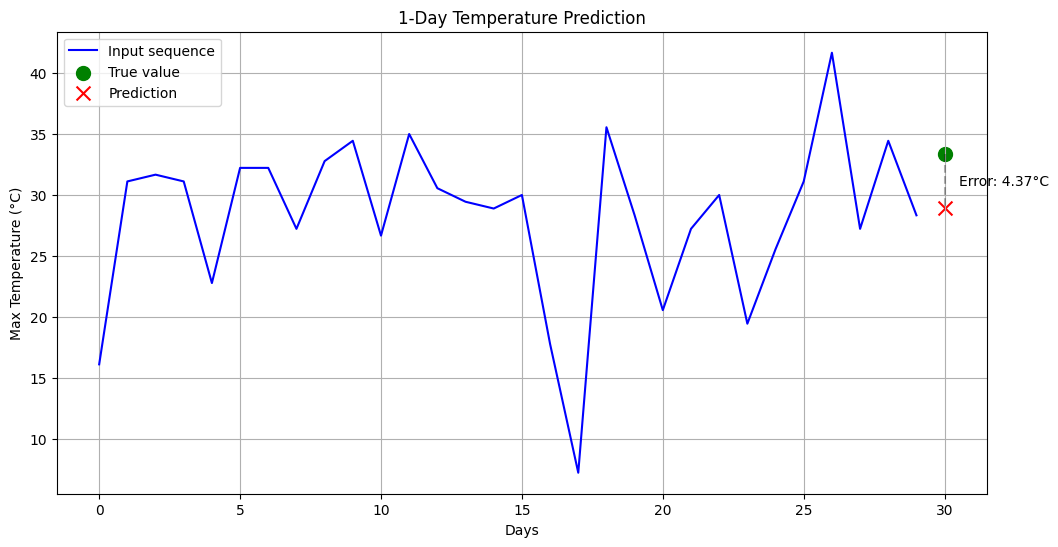

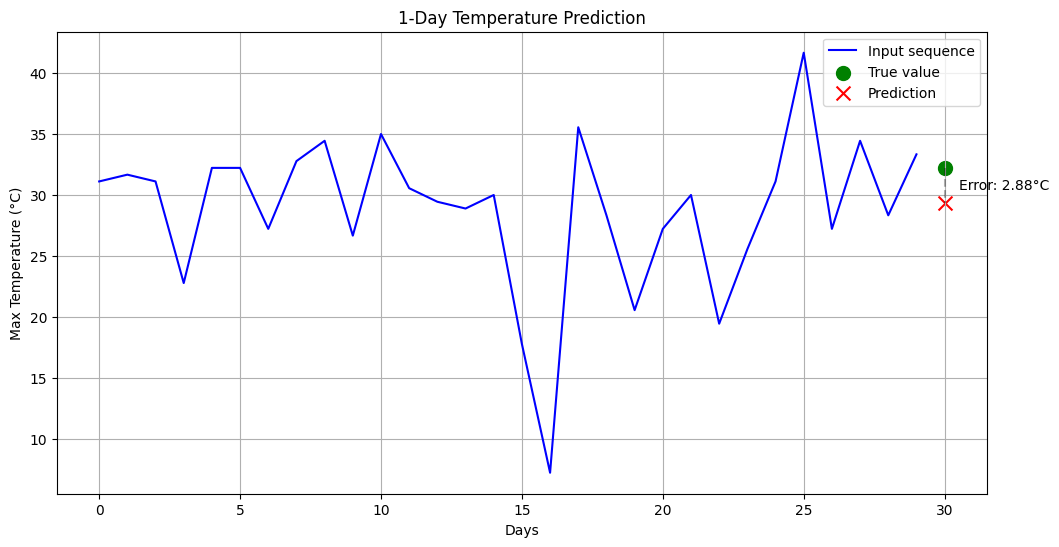

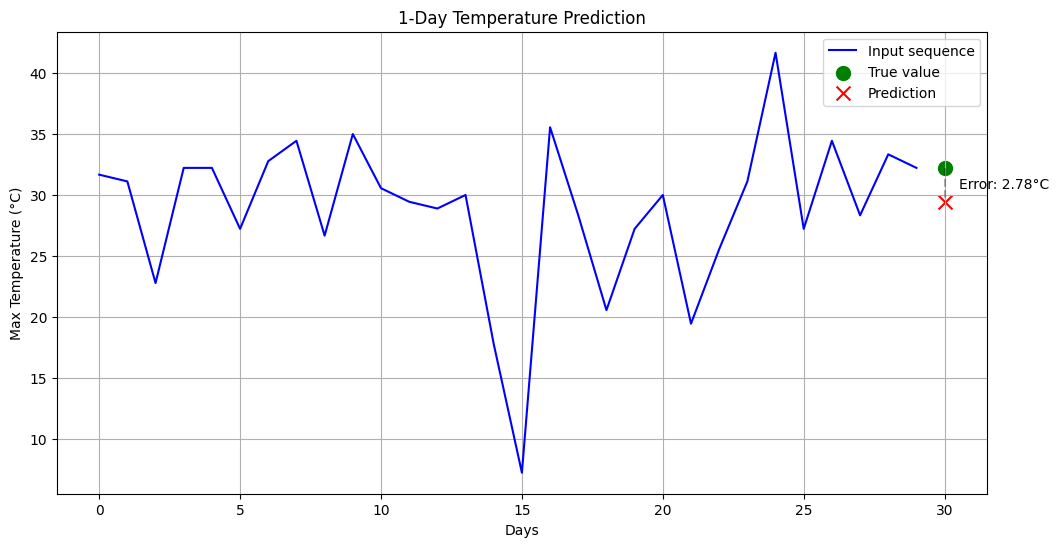

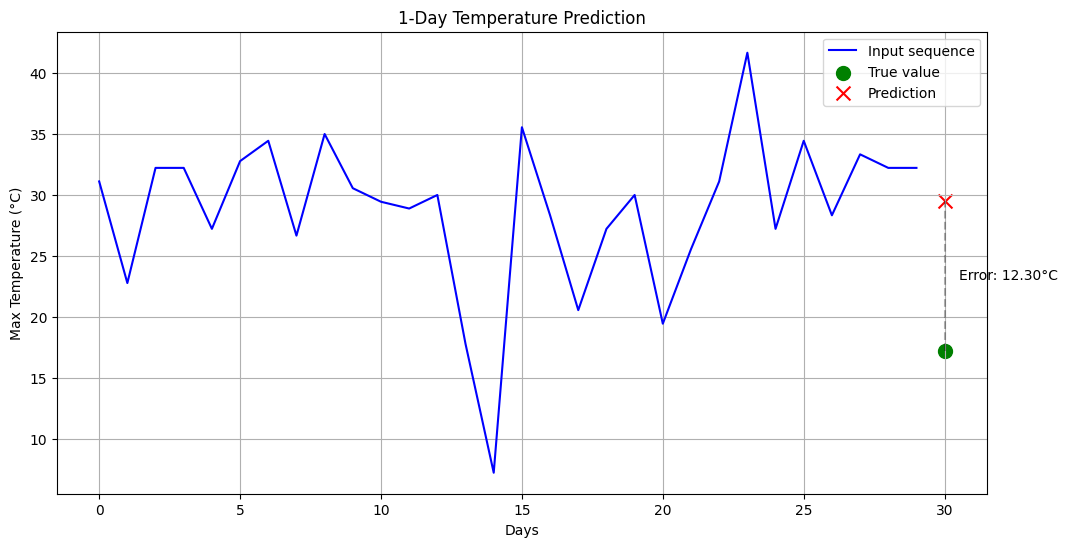

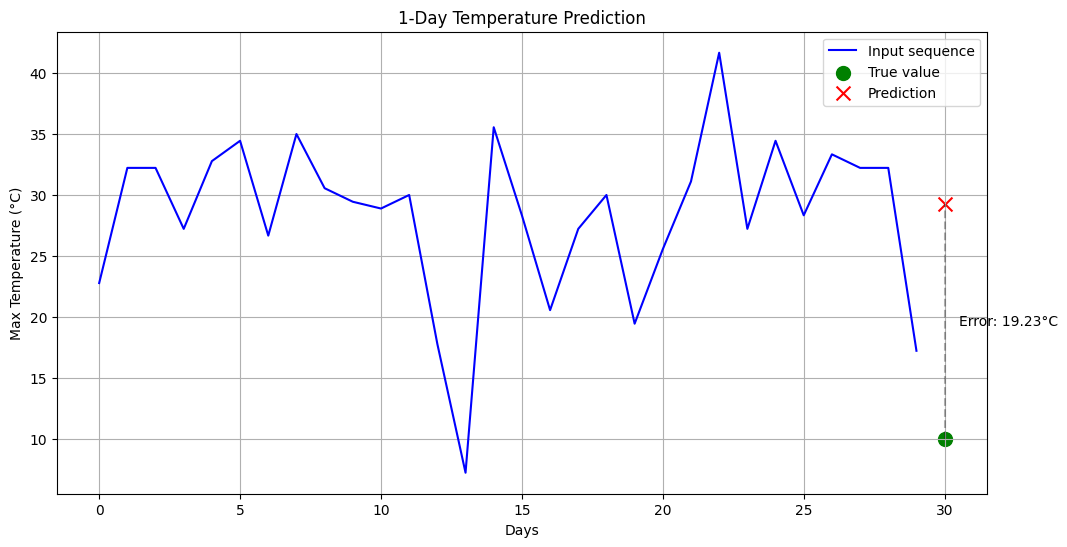

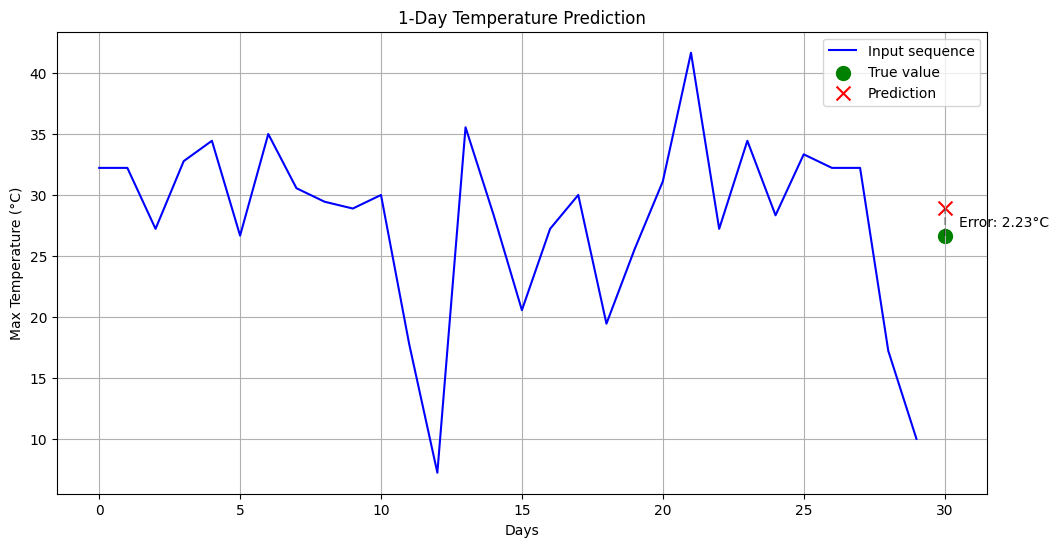

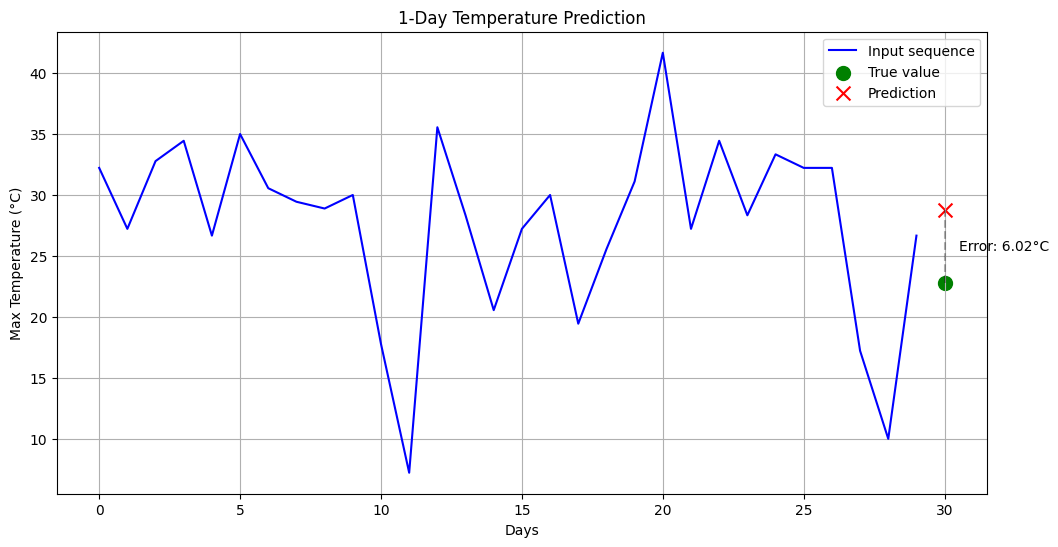

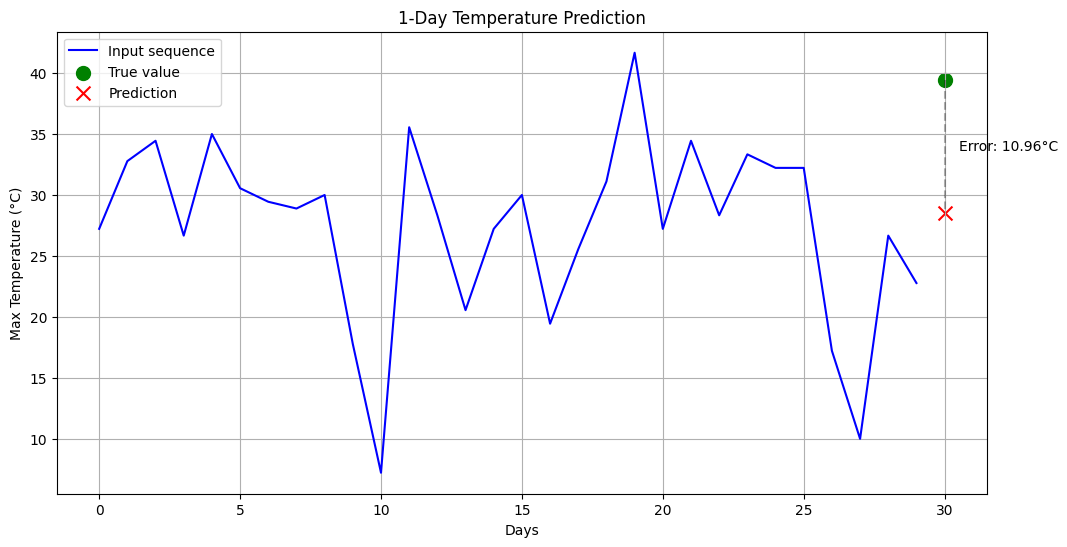

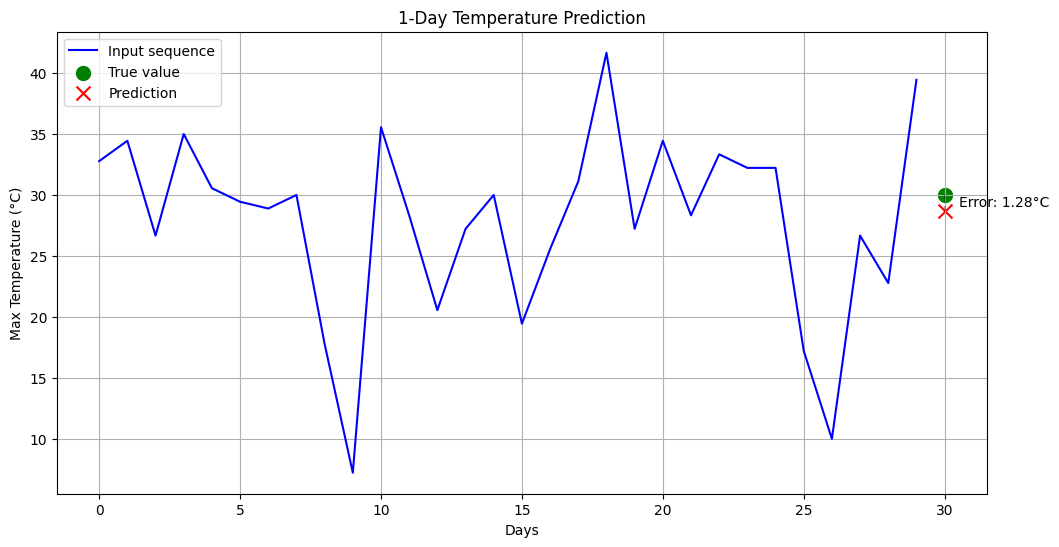

In [10]:
# 4. 可视化与预测（单日预测版本）
import matplotlib.pyplot as plt

def plot_predictions(model, dataset, scaler, idx=0, seq_length=30):
    model.eval()
    with torch.no_grad():
        x, y_true = dataset[idx]  # 现在y_true是单值
        x = x.unsqueeze(0).to(device)
        pred = model(x)  # 只获取单日预测
        
    # 反归一化（确保所有输入都是二维数组）
    x = scaler.inverse_transform(x.cpu().squeeze().numpy().reshape(-1, 1))
    y_true = scaler.inverse_transform(y_true.cpu().numpy().reshape(-1, 1))
    pred = scaler.inverse_transform(pred.cpu().numpy().reshape(-1, 1))
    
    # 转换为1D数组用于绘图
    x = x.flatten()
    y_true = y_true.item()  # 获取标量值
    pred = pred.item()      # 获取标量值
    
    # 绘制输入序列
    plt.figure(figsize=(12, 6))
    plt.plot(range(seq_length), x, 'b-', label='Input sequence')
    
    # 绘制真实值和预测值（单日）
    plt.scatter(seq_length, y_true, color='green', marker='o', s=100, label='True value')
    plt.scatter(seq_length, pred, color='red', marker='x', s=100, label='Prediction')
    
    # 添加连接线显示误差
    plt.plot([seq_length, seq_length], [y_true, pred], 'k--', alpha=0.3)
    
    # 添加误差文本
    error = abs(y_true - pred)
    plt.text(seq_length+0.5, (y_true + pred)/2, 
             f'Error: {error:.2f}°C', 
             verticalalignment='center')

    plt.legend()
    plt.title('1-Day Temperature Prediction')
    plt.xlabel('Days')
    plt.ylabel('Max Temperature (°C)')
    plt.grid(True)
    plt.show()

# 绘制几个示例
for i in range(10):
    plot_predictions(model, test_dataset, scaler, idx=i)
